In [1]:
import os 
import sys
import pandas as pd
import numpy as np
from umap import UMAP
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as plt
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from nltk.classify import ClassifierI
from statistics import mode
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

In [2]:
# NLTK English stopwords
nlp = spacy.load("en_core_web_lg")
nltk.download('stopwords') 
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_sp = nltk.corpus.stopwords.words('spanish')
stopwords_fr = nltk.corpus.stopwords.words('french')
stopwords_it = nltk.corpus.stopwords.words('italian')
stopwords = stopwords_en + stopwords_sp + stopwords_fr + stopwords_it


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylenabors/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

#Importing Configs
# Define the path where config.py is located
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [4]:

#Variables, Paramaters, and Pathnames needed for this script
database_file = config.database
database_folder = config.database_folder
bert_models = config.bert_models
bert_models_local = config.bert_models_local
keywords = config.keywords
Sentiment_models = config.Sentiment_models

In [5]:
Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
Model_Folder = config.texts
Model_Folder = Model_Folder + Model_Subfolder

df = pd.read_csv(f"{Model_Folder}/{Model}_texts.csv")  
df = df[df['language'] == 'en']

Body_2 = config.Body_2
Model_2 = config.Model_2
Model_Subfolder_2 = f'/{Body_2} Texts/{Model_2}'
Model_Folder_2 = config.texts
Model_Folder_2 = Model_Folder_2 + Model_Subfolder_2

df_2 = pd.read_csv(f"{Model_Folder_2}/{Model_2}_texts.csv",lineterminator='\n')  


In [6]:
df_all = pd.concat([df, df_2], axis=0)
#df_all = df_all.drop(columns=['Unnamed: 0'], inplace=True)
out = []
print(df.head())
print(df_2.head())
print(df_all)

   Unnamed: 0        date                                title  \
0           0  2023-08-31  Disinflation and the Phillips curve   
1           1  2023-08-31  Disinflation and the Phillips curve   
2           2  2023-08-31  Disinflation and the Phillips curve   
3           3  2023-08-31  Disinflation and the Phillips curve   
4           4  2023-08-31  Disinflation and the Phillips curve   

              type                                            segment  \
0  Isabel Schnabel  speech disinflation and the phillips curve spe...   
1  Isabel Schnabel  activity has moderated visibly , and forwardlo...   
2  Isabel Schnabel  but important pockets of resilience remain , e...   
3  Isabel Schnabel  headline inflation has come down , mainly on t...   
4  Isabel Schnabel  but underlying price pressures remain stubborn...   

  language  lang_prob  
0       en   0.999998  
1       en   0.999998  
2       en   0.999998  
3       en   0.999998  
4       en   0.999998  
   Unnamed: 0       

In [7]:
sia = SentimentIntensityAnalyzer()

# #VADER Analysis 
for index, row in df_all.iterrows():
    docs = row["segment"]
    timestamps = row['date']
    type = row['type']
    title = row['title']
    docs = str(docs)
    
    good = sia.polarity_scores(docs)['pos']
    bad = sia.polarity_scores(docs)['neg']
    neutral = sia.polarity_scores(docs)['neu']
    compound = sia.polarity_scores(docs)['compound']
    out.append([timestamps, title, type, docs, good, bad, neutral, compound])
    
df_out = pd.DataFrame(out, columns=["date", "title", "type", "segment","good", "bad", "neutral", "compound"])

df_out.to_csv(f"{Model_Folder}/{Model}_vader_sentiment_texts.csv")  
print(df_out.head())


         date                                title             type  \
0  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
1  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
2  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
3  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
4  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   

                                             segment   good    bad  neutral  \
0  speech disinflation and the phillips curve spe...  0.056  0.036    0.908   
1  activity has moderated visibly , and forwardlo...  0.000  0.237    0.763   
2  but important pockets of resilience remain , e...  0.196  0.000    0.804   
3  headline inflation has come down , mainly on t...  0.000  0.167    0.833   
4  but underlying price pressures remain stubborn...  0.000  0.242    0.758   

   compound  
0    0.1045  
1   -0.4215  
2    0.2960  
3   -0.3818  
4   -0.7227  


In [8]:

#Adding Custom Sentiment Analysis 
increase_words = ['increase', 'raise', 'increasing', 'raising', 'higher', 'hike', 'hiking', 'increases', 'raises', 'hikes']
decrease_words = ['decrease', 'lower', 'decline', 'declining', 'cut', 'cutting', 'reducing', 'reduction', 'reduce']
funds_words = ['interest', 'rate', 'funds', 'federal funds', 'points']


pos_train = []
neg_train = []
neutral_data = []
other_data = []

for index, row in df_all.iterrows():

    docs = row["segment"]
    title = row["title"]
    timestamps = row['date']
    type = row['type']
    docs = str(docs)

    interest = 0
    increase = 0
    decrease = 0
    good = 0
    bad = 0
    neutral = 0
    
    for word in docs.split():
        word = word.casefold()
        if word in funds_words:
            interest = 1
            
        if word in increase_words:
            increase = 1
 
        if word in decrease_words:
            decrease = 1
        
        if interest == 1 and increase == 1:
            bad = 1
            
        if interest == 1 and decrease == 1:
            good = 1  
        
        if interest == 1 and increase == 0 and decrease == 0:
            neutral = 1
    
    if good == 1:
        pos_train.append([timestamps, title, type, docs, interest, increase, decrease, good, bad, neutral])
        
    if bad == 1:
        neg_train.append([timestamps, title, type, docs, interest, increase, decrease, good, bad, neutral])
        
    if neutral == 1:
        neutral_data.append([timestamps, title, type, docs, interest, increase, decrease, good, bad, neutral])
        
    if good == 0 and bad == 0:
        other_data.append([timestamps, title, type, docs, interest, increase, decrease, good, bad, neutral])
    
    out.append([timestamps, type, docs, title, interest, increase, decrease, good, bad, neutral])


print(len(pos_train))
print(len(neg_train))


4937
5232


In [9]:

all_words = []
documents = []

#  j is adject, r is adverb, and v is verb
allowed_word_types = ["J","R","V"]
#allowed_word_types = ["J"]

# pos_train = pd.DataFrame(pos_train, columns=["date", "type", title, "segment", "interest", "increase", "decrease", "good", "bad", "neutral"])
# for index, row in pos_train.iterrows():
#     docs = row["segment"]
#     timestamps = row['date']
#     type = row['type']
#     docs = str(docs)

#     documents.append( (docs, "pos") )

#     #Tokenize 
#     tokenized = word_tokenize(docs)

#     #Remove Stopwords 
#     cleaned = [w for w in tokenized if not w in stopwords]

#     # parts of speech tagging for each word 
#     pos = nltk.pos_tag(cleaned)

#     # make a list of  all adjectives identified by the allowed word types list above
#     for w in pos:
#         if w[1][0] in allowed_word_types:
#             all_words.append(w[0].lower())
    
    
# neg_train = pd.DataFrame(neg_train, columns=["date", title, "type", "segment", "interest", "increase", "decrease", "good", "bad", "neutral"])

# for index, row in neg_train.iterrows():

#     docs = row["segment"]
#     timestamps = row['date']
#     type = row['type']
#     docs = str(docs)

#     documents.append( (docs, "neg") )
    
#     #Tokenize
#     tokenized = word_tokenize(docs)
    
#     #Remove Stopwords
#     cleaned = [w for w in tokenized if not w in stopwords]
    
#     # parts of speech tagging for each word 
#     neg = nltk.pos_tag(cleaned)
    
#     #Parts of the Speech Tagging for each word 
#     for w in neg:
#         if w[1][0] in allowed_word_types:
#             all_words.append(w[0].lower())
    
    

In [10]:

for index, row in df_out.iterrows():  
    good = row["good"]
    bad = row["bad"]
    if good > 0.5:
        docs = row["segment"]
        title = row["title"]
        timestamps = row['date']
        type = row['type']
        docs = str(docs)
        
        documents.append( (docs, "pos") )
        
        #Tokenize 
        tokenized = word_tokenize(docs)

        #Remove Stopwords 
        cleaned = [w for w in tokenized if not w in stopwords]
        
        # parts of speech tagging for each word 
        pos = nltk.pos_tag(cleaned)
        
        # make a list of  all adjectives identified by the allowed word types list above
        for w in pos:
            if w[1][0] in allowed_word_types:
                all_words.append(w[0].lower())
    

for index, row in df_out.iterrows():

    bad = row["bad"]
    if bad > 0.5:
        docs = row["segment"]
        title = row["title"]
        timestamps = row['date']
        type = row['type']
        docs = str(docs)

        documents.append( (docs, "neg") )
        
        #Tokenize
        tokenized = word_tokenize(docs)
        
        #Remove Stopwords
        cleaned = [w for w in tokenized if not w in stopwords]
        
        # parts of speech tagging for each word 
        neg = nltk.pos_tag(cleaned)
        
        #Parts of the Speech Tagging for each word 
        for w in neg:
            if w[1][0] in allowed_word_types:
                all_words.append(w[0].lower())

print(len(all_words))

pos_A = []
for w in pos:
    if w[1][0] in allowed_word_types:
        pos_A.append(w[0].lower())
        
pos_N = []
for w in neg:
    if w[1][0] in allowed_word_types:
        pos_N.append(w[0].lower())



4762


In [11]:

# from wordcloud import WordCloud
# text = ' '.join(pos_A)
# wordcloud = WordCloud().generate(text)

# plt.figure(figsize = (15, 9))
# # Display the generated image:
# plt.imshow(wordcloud, interpolation= "bilinear")
# plt.axis("off")
# plt.show()

Baysian Machine Learning Classifier Accuracy:93.97%
Most Informative Features
               difficult = True              neg : pos    =     18.9 : 1.0
               sovereign = True              neg : pos    =     16.8 : 1.0
                suffered = True              neg : pos    =     16.4 : 1.0
                    risk = True              neg : pos    =     14.8 : 1.0
                     bad = True              neg : pos    =     13.9 : 1.0
                 include = True              neg : pos    =     11.4 : 1.0
                    lack = True              neg : pos    =     11.4 : 1.0
                negative = True              neg : pos    =     11.4 : 1.0
                    high = True              neg : pos    =      9.2 : 1.0
               including = True              neg : pos    =      8.8 : 1.0
                   lower = True              neg : pos    =      8.8 : 1.0
                   asian = True              neg : pos    =      6.3 : 1.0
                    ha

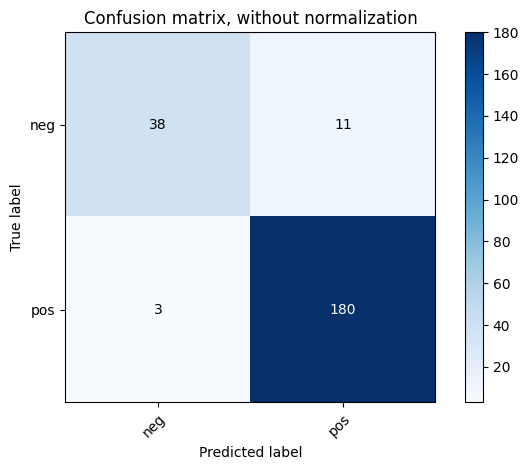

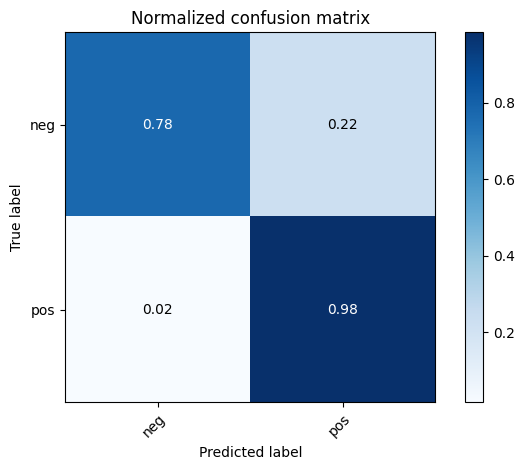

MNB_classifier accuracy percent: 93.53448275862068
BernoulliNB_classifier accuracy percent: 88.36206896551724
LogisticRegression_classifier accuracy percent: 87.93103448275862
SGDClassifier_classifier accuracy percent: 89.22413793103449
SVC_classifier accuracy percent: 85.34482758620689
f1_score ONB: 0.9396551724137931
f1_score MNB: 0.9353448275862069
f1_score BNB: 0.8836206896551724
f1_score LogReg: 0.8793103448275863
f1_score SGD: 0.8922413793103449
f1_score SVC: 0.853448275862069
Accuracy_score ONB: 0.9396551724137931
Accuracy_score MNB: 0.9353448275862069
Accuracy_score BNB: 0.8836206896551724
Accuracy_score LogReg: 0.8793103448275862
Accuracy_score SGD: 0.8922413793103449
Accuracy_score SVC: 0.853448275862069


In [12]:

# pickling the list documents to save future recalculations 
save_documents = open(f'{Sentiment_models}/pickled_algos/documents.pickle', "wb")
pickle.dump(documents, save_documents)
save_documents.close()

BOW = nltk.FreqDist(all_words)
BOW

word_features = list(BOW.keys())[:5000]
word_features[0], word_features[-1]

save_word_features = open(f'{Sentiment_models}/pickled_algos/word_features5k.pickle', "wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# Creating features for each review
featuresets = [(find_features(doc), category) for (doc, category) in documents]
fs_scale = len(featuresets)

# Shuffling the documents 
random.shuffle(featuresets)

ts_var = fs_scale * 0.85
ts_var = int(ts_var)

training_set = featuresets[:ts_var]
testing_set = featuresets[ts_var:]

classifier = nltk.NaiveBayesClassifier.train(training_set)

accuracy = nltk.classify.accuracy(classifier, testing_set) * 100
accuracy = str(round(accuracy, 2))
print(f"Baysian Machine Learning Classifier Accuracy:{accuracy}%")

classifier.show_most_informative_features(15)

mif = classifier.most_informative_features()
mif = [a for a,b in mif]
print(mif)

ground_truth = [r[1] for r in testing_set]

preds = [classifier.classify(r[0]) for r in testing_set]

f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# training various models by passing in the sklearn models into the SklearnClassifier from NLTK 

MNB_clf = SklearnClassifier(MultinomialNB())
MNB_clf.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)

BNB_clf = SklearnClassifier(BernoulliNB())
BNB_clf.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)

LogReg_clf = SklearnClassifier(LogisticRegression())
LogReg_clf.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)

SGD_clf = SklearnClassifier(SGDClassifier())
SGD_clf.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGD_clf, testing_set))*100)

SVC_clf = SklearnClassifier(SVC())
SVC_clf.train(training_set)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)

def create_pickle(c, file_name): 
    save_classifier = open(file_name, 'wb')
    pickle.dump(c, save_classifier)
    save_classifier.close()

classifiers_dict = {'ONB': [classifier, f'{Sentiment_models}/pickled_algos/ONB_clf.pickle'],
                    'MNB': [MNB_clf, f'{Sentiment_models}/pickled_algos/MNB_clf.pickle'],
                    'BNB': [BNB_clf, f'{Sentiment_models}/pickled_algos/BNB_clf.pickle'],
                    'LogReg': [LogReg_clf, f'{Sentiment_models}/pickled_algos/LogReg_clf.pickle'],
                    'SGD': [SGD_clf, f'{Sentiment_models}/pickled_algos/SGD_clf.pickle'], 
                    'SVC': [SVC_clf, f'{Sentiment_models}/pickled_algos/SVC_clf.pickle']}

for clf, listy in classifiers_dict.items(): 
    create_pickle(listy[0], listy[1])


ground_truth = [r[1] for r in testing_set]
predictions = {}
f1_scores = {}
acc_scores = {}

for clf, listy in classifiers_dict.items(): 
    predictions[clf] = [listy[0].classify(r[0]) for r in testing_set]
    f1_scores[clf] = f1_score(ground_truth, predictions[clf], labels = ['neg', 'pos'], average = 'micro')
    print(f'f1_score {clf}: {f1_scores[clf]}')
    
for clf, listy in classifiers_dict.items(): 
    acc_scores[clf] = accuracy_score(ground_truth, predictions[clf])
    print(f'Accuracy_score {clf}: {acc_scores[clf]}')
    
from nltk.classify import ClassifierI

# Defininig the ensemble model class 
class EnsembleClassifier(ClassifierI):
    
    def __init__(self, *classifiers):
        self._classifiers = classifiers
    
    # returns the classification based on majority of votes
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)
    # a simple measurement the degree of confidence in the classification 
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf
# function to load models given filepath
def load_model(file_path): 
    classifier_f = open(file_path, "rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    return classifier

# Original Naive Bayes Classifier
ONB_Clf = load_model(f'{Sentiment_models}/pickled_algos/ONB_clf.pickle')

# Multinomial Naive Bayes Classifier 
MNB_Clf = load_model(f'{Sentiment_models}/pickled_algos/MNB_clf.pickle')

# Bernoulli  Naive Bayes Classifier 
BNB_Clf = load_model(f'{Sentiment_models}/pickled_algos/BNB_clf.pickle')

# Logistic Regression Classifier 
LogReg_Clf = load_model(f'{Sentiment_models}/pickled_algos/LogReg_clf.pickle')

# Stochastic Gradient Descent Classifier
SGD_Clf = load_model(f'{Sentiment_models}/pickled_algos/SGD_clf.pickle')

# Initializing the ensemble classifier 
ensemble_clf = EnsembleClassifier(ONB_Clf, MNB_Clf, BNB_Clf, LogReg_Clf, SGD_Clf)

# List of only feature dictionary from the featureset list of tuples 
feature_list = [f[0] for f in testing_set]

# Looping over each to classify each review
ensemble_preds = [ensemble_clf.classify(features) for features in feature_list]
    
f1_score(ground_truth, ensemble_preds, average = 'micro')

def sentiment(text):
    feats = find_features(text)
    return ensemble_clf.classify(feats), ensemble_clf.confidence(feats)   

def sentiment_out_class(text):
    feats = find_features(text)
    return ensemble_clf.classify(feats)

def sentiment_out_conf(text):
    feats = find_features(text)
    return ensemble_clf.confidence(feats)   

other_data = pd.DataFrame(other_data, columns=["date", "title", "type", "segment", "interest", "increase", "decrease", "good", "bad", "neutral"])


In [13]:

advanced_sent = []

print('Start Advanced Sentiment Analysis')
for index, row in df.iterrows():
    date = row["date"]
    title = row["title"]
    type = row["type"]
    segment = row["segment"]
    feats = find_features(segment)
    seg_class = ensemble_clf.classify(feats)
    seg_conf = ensemble_clf.confidence(feats)  
    
    advanced_sent.append([date, title, type, segment, seg_class, seg_conf])
    
out_advanced_sent = pd.DataFrame(advanced_sent, columns=["date", "title", "type", "segment", "sentiment", "confidence"])
print(out_advanced_sent.head())
out_advanced_sent.to_csv(f"{Sentiment_models}/{Body}_{Model}_advanced_sentiment_texts.csv")


Start Advanced Sentiment Analysis
         date                                title             type  \
0  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
1  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
2  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
3  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   
4  2023-08-31  Disinflation and the Phillips curve  Isabel Schnabel   

                                             segment sentiment  confidence  
0  speech disinflation and the phillips curve spe...       neg         0.6  
1  activity has moderated visibly , and forwardlo...       pos         1.0  
2  but important pockets of resilience remain , e...       pos         1.0  
3  headline inflation has come down , mainly on t...       pos         1.0  
4  but underlying price pressures remain stubborn...       neg         1.0  


In [14]:

advanced_sent_2 = []

for index, row in df_2.iterrows():
    date = row["date"]
    title = row["title"]
    type = row["type"]
    segment = row["segment"]
    feats = find_features(segment)
    seg_class = ensemble_clf.classify(feats)
    seg_conf = ensemble_clf.confidence(feats)  
    
    advanced_sent_2.append([date, title, type, segment, seg_class, seg_conf])
    
out_advanced_sent_2 = pd.DataFrame(advanced_sent_2, columns=["date", "title", "type", "segment", "sentiment", "confidence"])
print(out_advanced_sent_2.head())
out_advanced_sent_2.to_csv(f"{Sentiment_models}/{Body_2}_{Model_2}_advanced_sentiment_texts.csv")



         date                            title                        type  \
0  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
1  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
2  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
3  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
4  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   

                                             segment sentiment  confidence  
0  i discovered when i joined the board of govern...       pos         0.8  
1  many of them said , enthusiastically , congrat...       pos         1.0  
2  then they asked with a bit of embarrassment , ...       pos         1.0  
3     or what will you find to do between meetings ?       pos         1.0  
4  the meetings they were aware of , of course , ...       pos         1.0  


In [15]:

advanced_sent_all = []

for index, row in df_all.iterrows():
    date = row["date"]
    title = row["title"]
    type = row["type"]
    segment = row["segment"]
    feats = find_features(segment)
    seg_class = ensemble_clf.classify(feats)
    seg_conf = ensemble_clf.confidence(feats)  
    
    advanced_sent_all.append([date, title, type, segment, seg_class, seg_conf])
    
out_advanced_sent_all = pd.DataFrame(advanced_sent_2, columns=["date", "title", "type", "segment", "sentiment", "confidence"])
print(out_advanced_sent_all.head())
out_advanced_sent_all.to_csv(f"{Sentiment_models}/all_advanced_sentiment_texts.csv")

print('Finshed Advanced Sentiment Analysis')


         date                            title                        type  \
0  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
1  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
2  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
3  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   
4  19961219.0  Supervision of bank risk-taking  Vice Chair Alice M. Rivlin   

                                             segment sentiment  confidence  
0  i discovered when i joined the board of govern...       pos         0.8  
1  many of them said , enthusiastically , congrat...       pos         1.0  
2  then they asked with a bit of embarrassment , ...       pos         1.0  
3     or what will you find to do between meetings ?       pos         1.0  
4  the meetings they were aware of , of course , ...       pos         1.0  
Finshed Advanced Sentiment Analysis


In [16]:
exit()

df_out = pd.DataFrame(out, columns=["date", "title", "type", "segment", "interest", "increase", "decrease", "good", "bad", "neutral"])
df_out.to_csv(f"{Model_Folder}/{Model}_sentiment_texts.csv")  

: 